# Descriptive Statistics

In [1]:
# Settings and imports.
%matplotlib inline
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns
import data

sns.set()
sns.set_context('poster')
#sns.set_style('whitegrid')
pd.options.display.float_format = '{:.2f}'.format

# Preparing Data

In [2]:
ts = data.load('robomission-2018-03-10/task_sessions.csv')
# Only consider sessions with an interaction.
ts = ts[ts.time_spent > 0]
# Set maximum spent time to 1h.
ts.time_spent = ts.time_spent.clip_upper(60 * 60)
ts = ts.assign(date=ts.end.str[:10])
ts.head(2)

,student,task,solved,start,end,time_spent,date
id,,,,,,,
39,917,26,False,2017-11-13T10:58:19.666306Z,2017-11-13T10:59:21.969801Z,62,2017-11-13
28,584,41,True,2017-11-12T08:57:39.741460Z,2017-11-12T08:58:43.087657Z,63,2017-11-12


In [3]:
tasks = data.load('robomission-2018-03-10/tasks.csv')
levels = data.load('robomission-2018-03-10/levels.csv')

In [4]:
snapshots = data.load('robomission-2018-03-10/program_snapshots.csv')
edits = snapshots[snapshots.granularity == 'edit']
executions = snapshots[snapshots.granularity == 'execution']
snapshots.head(2)

,task_session,time,program,granularity,order,correct,time_from_start,time_delta
id,,,,,,,,
1,1,2017-11-10T10:25:16.906946Z,f,edit,1,NaN,8,8
2,1,2017-11-10T10:25:17.965605Z,ff,edit,2,NaN,9,1


In [5]:
print('This data was collected between {start} and {end}.'
.format(start=ts.date.min(), end=ts.date.max()))

This data was collected between 2017-11-10 and 2018-03-09.


In [7]:
# TODO
# (Start: https://github.com/adaptive-learning/robomission/blob/master/backend/monitoring/notebooks/monitoring_template.ipynb)

# Global Stats

## Students

Number of students (tackled at least one task):
(Caveat: Single user may be counted multiple times if he
didn't sign up and the session cookie expired.)

In [8]:
ts.student.nunique()

970

Students who solved at least one task:

In [9]:
ts[ts.solved].student.nunique()

820

Number of returning students (= student who solved a task session in at least two distinct days):

In [10]:
sum(ts[ts.solved].groupby('student').date.nunique() >= 2)

102

## Task Sessions

Number of task sessions:

In [11]:
len(ts)

11117

Number of solved task sessions:

In [12]:
sum(ts.solved)

9594

Success rate (how many task sessions were solved):

In [13]:
sum(ts.solved) / len(ts)

0.8630026086174327

Overall time (mean, std), median, interquartile range:

In [14]:
ts.time_spent.describe()

count   11117.00
mean      194.99
std       495.93
min         2.00
25%        24.00
50%        60.00
75%       145.00
max      3600.00
Name: time_spent, dtype: float64

## Program snapshots

In [15]:
len(snapshots)

184194

In [16]:
len(edits)

144881

In [17]:
len(executions)

39313

# Metrics

In [18]:
grouped_ts = ts.groupby('date')
metrics = pd.DataFrame(OrderedDict(
    students=grouped_ts.student.nunique(),
    solving_hours=grouped_ts.time_spent.sum() / 3600,
    solved_count=grouped_ts.solved.sum(),
)).sort_index()
metrics.index = pd.to_datetime(metrics.index)

In [24]:
# Hack; to find the values for xlim, use: ax.get_xlim():
#ax.set_xlim(left=17474, right=17604)

(17474.05, 17604.95)

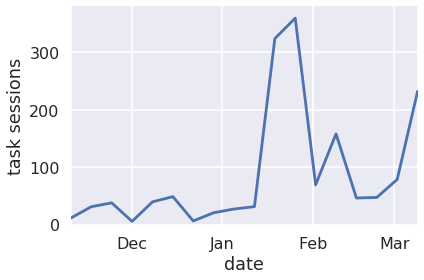

In [88]:
ax = metrics.solved_count.resample('7D').mean().plot()
ax.set_ylabel('task sessions')
ax.autoscale(tight=True)
ax.set_ylim(bottom=0, top=380)
# ax.set_xlabel('')
ax.set_xticklabels(['', 'Dec', 'Jan', 'Feb', 'Mar'])
plt.tight_layout()
#plt.subplots_adjust(bottom=0.095) # this only trims the saved plot
plt.savefig('../img/daily-task-sessions.pdf')

# Difficulty Analysis

- what: success, time, clicks, (...)
- for tasks (grouped by levels - homogenity test) / levels
- distributions: log-time, n_clicks

Histogram of times:

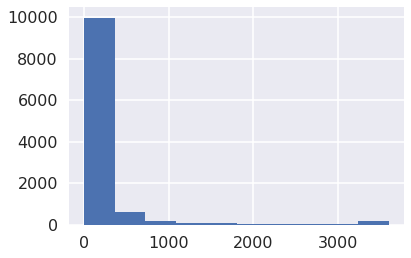

In [48]:
ts.time_spent.hist()

Histogram of log-times:

In [52]:
ax = ts.time_spent.hist?
ax.set_xlabel('log time (log sec)')
ax.set_ylabel('task sessions')
plt.tight_layout()
#plt.savefig('../img/task-sessions-time-log.pdf')

In [ ]:
ax = ts.time_spent.hist()

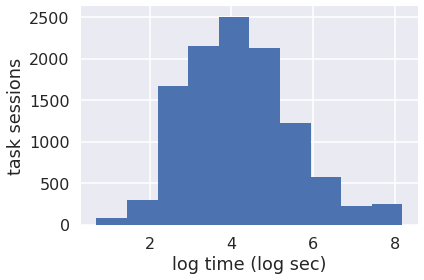

In [62]:
ax = ts.time_spent.apply(np.log).hist()
ax.set_xlabel('log time (log sec)')
ax.set_ylabel('task sessions')
plt.tight_layout()
#plt.savefig('../img/task-sessions-time-log.pdf')

In [74]:
ax.set_yscale?

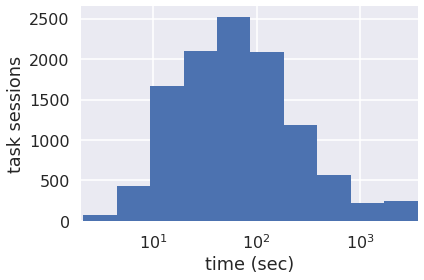

In [76]:
logbins = np.logspace(np.log10(1),np.log10(3600),12)
ax = ts.time_spent.hist(bins=logbins)
ax.set_xscale('log')
ax.set_xlabel('time (sec)')
ax.set_ylabel('task sessions')
ax.set_xlim(left=2, right=3600)
plt.tight_layout()
#plt.savefig('../img/task-sessions-time-log.pdf')

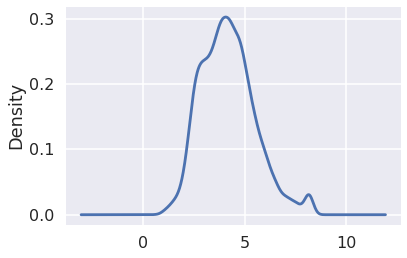

In [78]:
ax = ts.time_spent.apply(np.log).plot.kde()
#plt.gca().set_xscale("log")

## Levels Difficulty

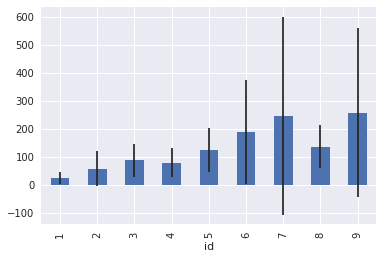

In [169]:
# TODO: replace by a boxplot/violinplot
g = ts.merge(tasks, left_on='task', right_index=True).groupby('level')
level_stats = levels.merge(
    g.time_spent.describe(), left_on='name', right_index=True)
iqr = level_stats['75%'] - level_stats['25%']
level_stats['50%'].plot.bar(yerr=iqr/2)

In [17]:
df.groupby('level').median().sort_values('level_value')['time_spent']

level
moves              24.00
world              58.00
repeat             87.00
while              79.00
loops             123.50
if                188.00
comparing         246.50
if-else           136.00
final-challenge   257.00
Name: time_spent, dtype: float64

(0, 9.58905139036212)

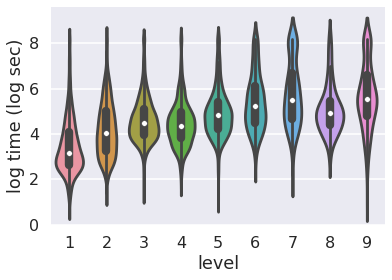

In [7]:
df = ts.merge(tasks, left_on='task', right_index=True)
df = df.merge(
    levels, left_on='level', right_on='name',
    suffixes=('', '_value'))
df = df.assign(time_log=df.time_spent.apply(np.log))
ax = sns.violinplot(data=df, x='level_value', y='time_log')
ax.set_xlabel('level')
ax.set_ylabel('log time (log sec)')
ax.set_ylim(bottom=0)
#plt.tight_layout()
#plt.savefig('../img/levels-time.pdf')

## Time vs. Edits

In [68]:
ts_edits = edits.groupby('task_session').program.count()
ts = ts.assign(edits=ts_edits)
ts.edits = ts.edits.fillna(0)

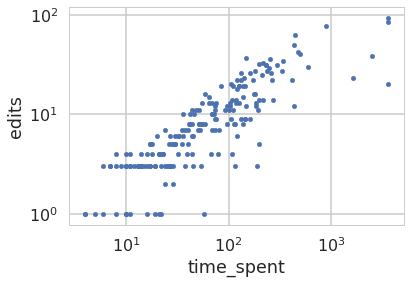

In [69]:
ts.sample(n=200).plot.scatter(
    x='time_spent', y='edits',
    logx=True, logy=True)

The correlation between the log-time and log-edits is quite high:

In [70]:
times_log = ts.time_spent.apply(np.log)
edits_log = (ts.edits + 1).apply(np.log)
times_log.corr(edits_log)

0.73190121566360433

TODO: look at correlations within a task.

## Tasks within Levels

In [142]:
# TODO? Limit to a single level to make it readable?

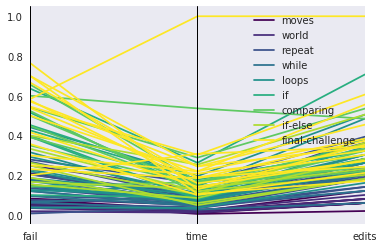

In [168]:
g = ts.groupby('task')
metrics = pd.DataFrame(OrderedDict(
    fail=1-g.solved.mean(),
    time=g.time_spent.median(),
    edits=g.edits.median(),
))
metrics.time /= metrics.time.max()
metrics.edits /= metrics.edits.max()
df = tasks.join(metrics).fillna(0)
df = df.merge(
    levels, left_on='level', right_on='name',
    suffixes=('', '_value'))
df = df.sort_values('level_value')
df = df[['level', 'fail', 'time', 'edits']]
parallel_coordinates(df, 'level', colormap='viridis')